In [140]:
import numpy as np
from pyod.models.lof import LOF
from pyod.utils.data import generate_data_clusters
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import make_blobs

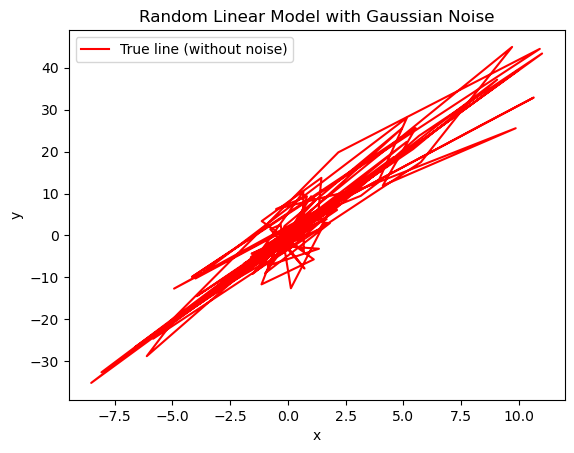

In [95]:


def generate_data_1d(n = 100,m = 25,mu = 0, sigma = 1.0,rng = None):

    a = 4
    b = -0.5

    # Standard distribution
    x_std = rng.normal(0,1.0,n)

    # Variance oscillation
    x_high_var_x = rng.normal(0,5.0,m)
    x_high_var_y = rng.normal(0,2.0,m)
    x_high_var_x_y = rng.normal(0,5.0,m)

    x = np.concatenate([x_std,x_high_var_x,x_high_var_y,x_high_var_x_y])

    # Noise

    epsilon_std = rng.normal(mu,sigma,n)
    epsilon_high_var_x = rng.normal(mu,sigma,m)
    epsilon_high_var_y = rng.normal(mu,6.0 * sigma,m)
    epsilon_high_var_x_y = rng.normal(mu,6.0 * sigma,m)

    epsilon = np.concatenate([epsilon_std,epsilon_high_var_x,epsilon_high_var_y,epsilon_high_var_x_y])

    y = a * x + b + epsilon
    return x,y




rng = np.random.default_rng(9000)
x,y = generate_data_1d(rng = rng)

# plt.scatter(x, y, label="Data (with noise)")
plt.plot(x, y, color="red", label="True line (without noise)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Random Linear Model with Gaussian Noise")
plt.show()


# EX 2

In [118]:

x_train,x_test,y_train, y_test = generate_data_clusters(n_train=400,
                                                        n_test=200,
                                                        n_clusters=2,
                                                        n_features=2,
                                                        contamination=0.1,
                                                        random_state=9000)

k_neighbours = [1,3,5,7,9,11,13,15,17,19,21,25,30,40,50]

for k in k_neighbours:
    model = KNN(n_neighbors=k,contamination=0.1)
    model.fit(x_train)
    y_pred = model.predict(x_test)
    ba = balanced_accuracy_score(y_test,y_pred)
    print(f" k = {k}, balanced accuracy = {ba}")

 k = 1, balanced accuracy = 0.9943820224719101
 k = 3, balanced accuracy = 0.9915730337078652
 k = 5, balanced accuracy = 0.9915730337078652
 k = 7, balanced accuracy = 0.997191011235955
 k = 9, balanced accuracy = 0.997191011235955
 k = 11, balanced accuracy = 0.9943820224719101
 k = 13, balanced accuracy = 0.997191011235955
 k = 15, balanced accuracy = 0.9943820224719101
 k = 17, balanced accuracy = 0.9887640449438202
 k = 19, balanced accuracy = 0.9943820224719101
 k = 21, balanced accuracy = 0.9915730337078652
 k = 25, balanced accuracy = 0.9943820224719101
 k = 30, balanced accuracy = 0.9943820224719101
 k = 40, balanced accuracy = 0.9915730337078652
 k = 50, balanced accuracy = 0.9943820224719101


/home/gabroveanu-razvan/anaconda3/envs/anomaly/lib/python3.13/site-packages/pyod/models/base.py:554: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


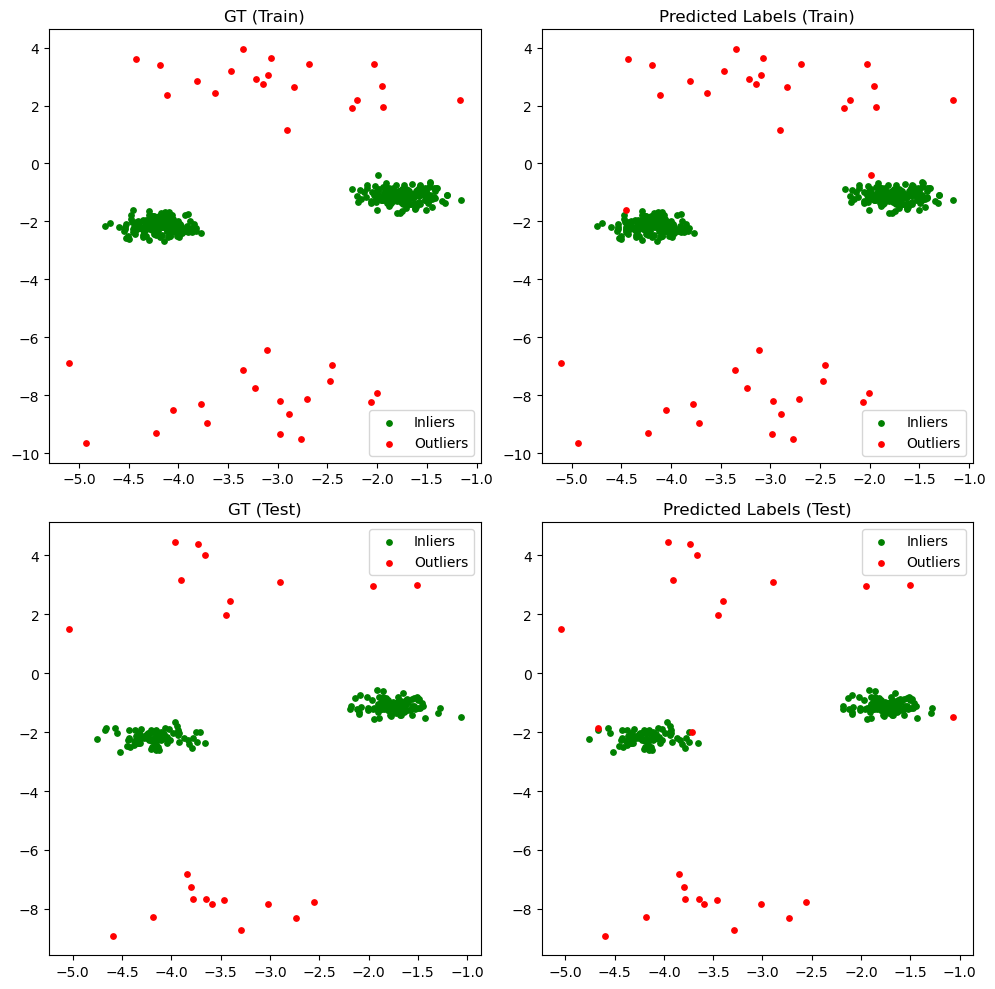

In [129]:

k = 5
model = KNN(n_neighbors=k,contamination=0.1)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
titles = [
    "GT (Train)",
    "Predicted Labels (Train)",
    "GT (Test)",
    "Predicted Labels (Test)",
]
data_sets = [
    (x_train, y_train),
    (x_train, y_train_pred),
    (x_test, y_test),
    (x_test, y_pred),
]

for ax, (X, y), title in zip(axes.ravel(), data_sets, titles):
    inliers = X[y == 0]
    outliers = X[y == 1]
    ax.scatter(inliers[:,0], inliers[:,1], c="green", label="Inliers", s=15)
    ax.scatter(outliers[:,0], outliers[:,1], c="red", label="Outliers", s=15)
    ax.set_title(title)
    ax.legend()

plt.tight_layout()

# EX 3

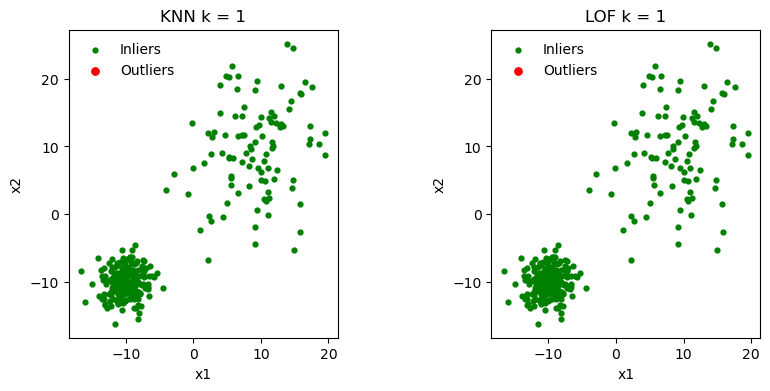

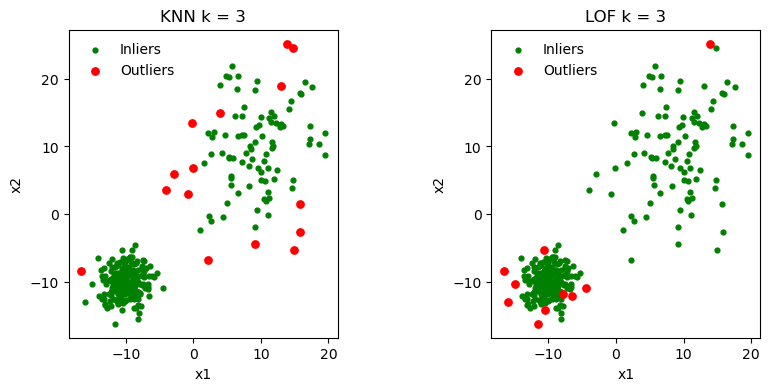

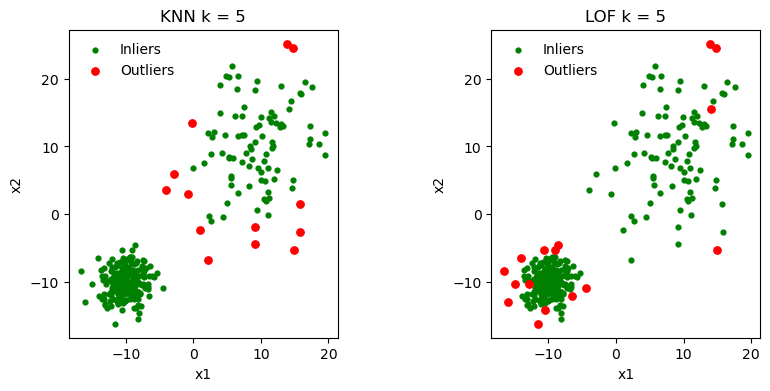

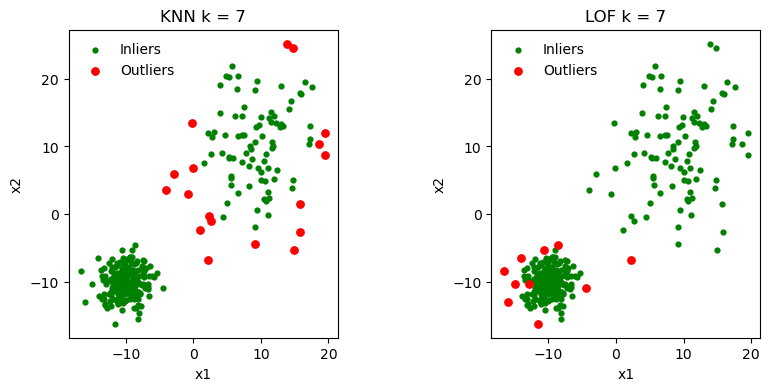

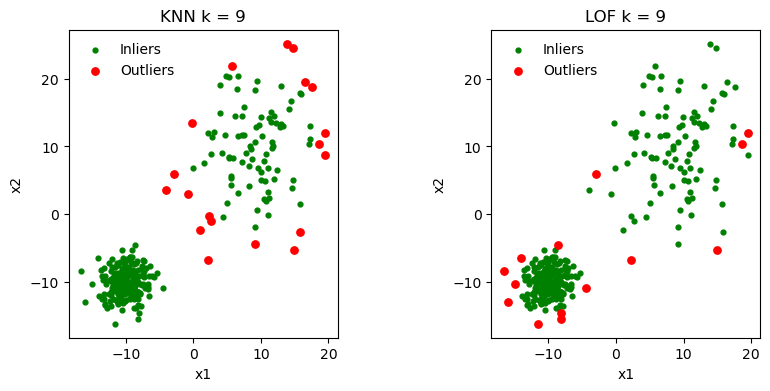

In [165]:
x, _ = make_blobs(
    n_samples=[200, 100],
    centers=[(-10, -10), (10, 10)],
    cluster_std=[2, 6],
    n_features=2,
    random_state=9000,
)

k_list = [1,3,5,7,9]

for k  in k_list:

    knn = KNN(n_neighbors=k,contamination=0.07)
    knn.fit(x)
    y_knn = knn.predict(x)

    lof = LOF(n_neighbors=k,contamination=0.07)
    lof.fit(x)
    y_lof = lof.predict(x)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4*1))

    # KNN plot
    inliers = y_knn == 0
    outliers = y_knn == 1

    knn_ax = axes[0]
    knn_ax.scatter(x[inliers, 0], x[inliers, 1], s=12, c="green", label="Inliers")
    knn_ax.scatter(x[outliers, 0], x[outliers, 1], s=28, c="red", label="Outliers")
    knn_ax.set_title(f"KNN k = {k}")
    knn_ax.set_xlabel("x1")
    knn_ax.set_ylabel("x2")
    knn_ax.legend(frameon=False, loc="best")
    knn_ax.set_aspect("equal", adjustable="box")


    # LOF plot
    inliers = y_lof == 0
    outliers = y_lof == 1

    lof_ax = axes[1]
    lof_ax.scatter(x[inliers, 0], x[inliers, 1], s=12, c="green", label="Inliers")
    lof_ax.scatter(x[outliers, 0], x[outliers, 1], s=28, c="red", label="Outliers")
    lof_ax.set_title(f"LOF k = {k}")
    lof_ax.set_xlabel("x1")
    lof_ax.set_ylabel("x2")
    lof_ax.legend(frameon=False, loc="best")
    lof_ax.set_aspect("equal", adjustable="box")


